# Détection de faux billets 💵

Dans la zone euro, on compte 17 faux billets en circulation pour 1 million d'authentiques, ratio en baisse constante chaque année. Parmi les outils de lutte contre le faux monnayage, le machine learning peut permettre de détecter ces fraudes, en s'appuyant sur des caractères quantitatifs comme les mesures des billets. 

Nous créerons ici un algorithme de détection des fausses billets, en partant d'un jeu de données contenant les caractéristiques géométriques de vraies et fausses coupures. La tâche consistera à limiter au maximum le nombre de faux billets prédits comme vrais.

On s'appuiera sur un clustering de type k-means pour vérifier la linéarité de nos données. Après cette confirmation, on pourra créer un classifieur de type régression logistique, modèle qu'on convertira en fonction autonome de détection.

**Sommaire**

- 1. [Analyse](#Analyse)
- 2. [ACP](#ACP)
- 3. [Clustering](#Clustering)
- 4. [Modélisation](#Modélisation)
- 5. [Programme de détection](#Programme-de-détection)
- [Ressources](#Ressources)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set(style='white', context='notebook', # Styles de Seaborn
        palette=['#ff5252', '#1de9b6'])

def save_fig(file_name): # Fonction d'export des graphiques
    return plt.savefig('graphiques/' + file_name, dpi=150, bbox_inches='tight')

# Analyse

## Présentation des données

Le fichier **notes.csv** liste les caractéristiques de 170 billets de banque différents. On dispose de l'authenticité de chaque billet (*True* ou *False*), et de 6 mesures toutes exprimées en millimètres : diagonale, hauteurs à gauche et à droite, marges hautes et basses, longueur.

Il n'y a aucune valeur manquante ou aberrante, aucun nettoyage n'est donc requis.

In [5]:
url = 'https://raw.githubusercontent.com/gllmfrnr/oc/master/p6/'
fichier = url + 'notes.csv'
df = pd.read_csv(fichier)
df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...,...
165,False,172.11,104.23,104.45,5.24,3.58,111.78
166,False,173.01,104.59,104.31,5.04,3.05,110.91
167,False,172.47,104.27,104.10,4.88,3.33,110.68
168,False,171.82,103.97,103.88,4.73,3.55,111.87


In [6]:
print(len(df) - len(df.drop_duplicates()), 'doublon') # Aucun doublon

0 doublon


In [7]:
df.info() # Aucune valeur manquante

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    170 non-null    bool   
 1   diagonal      170 non-null    float64
 2   height_left   170 non-null    float64
 3   height_right  170 non-null    float64
 4   margin_low    170 non-null    float64
 5   margin_up     170 non-null    float64
 6   length        170 non-null    float64
dtypes: bool(1), float64(6)
memory usage: 8.3 KB


In [8]:
df.describe() # Pas d'outliers

,diagonal,height_left,height_right,margin_low,margin_up,length
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500
max,173.010000,104.860000,104.950000,6.280000,3.680000,113.980000


On compte 100 vrais billets pour 70 faux.

In [9]:
df['is_genuine'].value_counts()

True     100
False     70
Name: is_genuine, dtype: int64

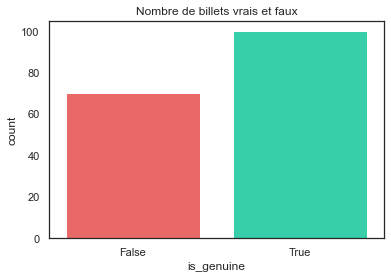

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='is_genuine')
plt.title('Nombre de billets vrais et faux')
save_fig('countplot_isgenuine')
plt.show()

## Analyse des corrélations

`sns.pairplot` trace l'histogramme de chaque variable quantitative, pour chaque classe de la variable catégorielle *is_genuine*.

La longueur et la marge basse permettent le mieux de discriminer les vrais billets des faux. 

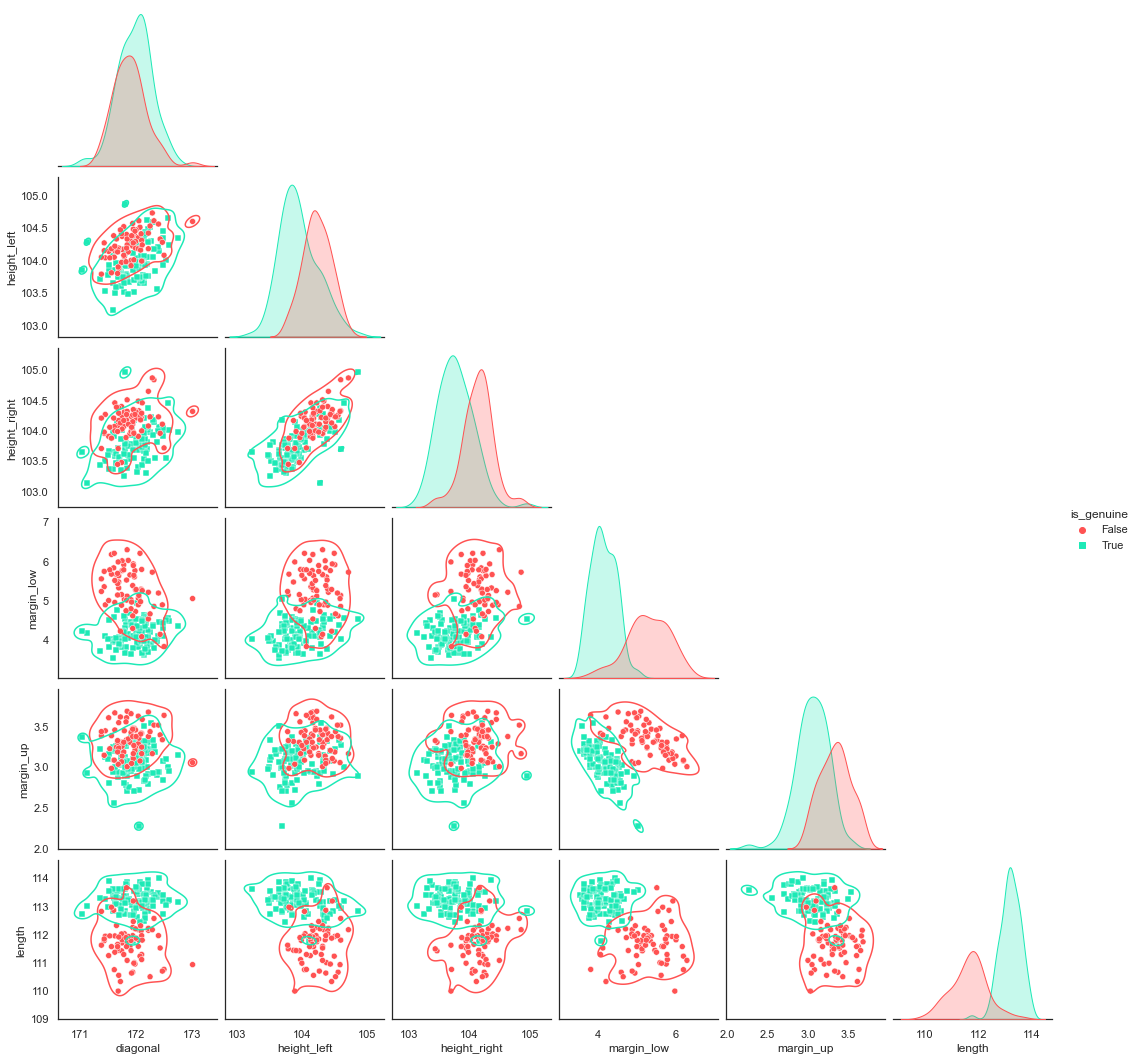

In [11]:
g = sns.pairplot(df, hue='is_genuine', markers=['o','s'], corner=True)
g.map_lower(sns.kdeplot, levels=2, color='.2')
save_fig('pairplot')
plt.show()

Les faux billets sont plus courts que les vrais, et leur marge basse est à l'inverse nettement plus longue.

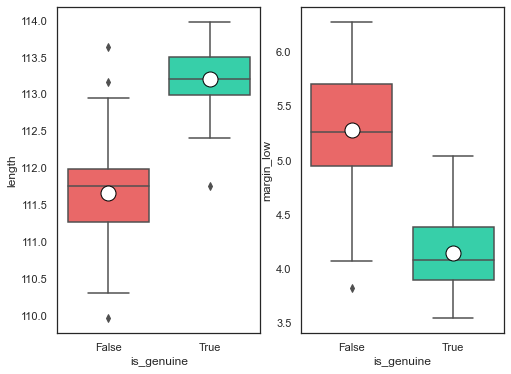

In [12]:
fig, ax = plt.subplots(1,2, figsize=(8,6))
meanprops = {"marker":"o","markerfacecolor":"white", "markeredgecolor":"black", "markersize":"15"}
sns.boxplot(data=df, y='length', x='is_genuine', showmeans=True, meanprops=meanprops, ax=ax[0])
sns.boxplot(data=df, y='margin_low', x='is_genuine', showmeans=True, meanprops=meanprops, ax=ax[1])
save_fig('boxplots')
plt.show()

La matrice des corrélations résume les dépendances entre variables par une valeur entre -1 et 1 :
- `0` : absence de corrélation
- `1` : corrélation positive
- `-1` : corrélation négative

Elle confirme l'impact de la longueur et de la marge basse sur l'authenticité (plus de 0.8 d'écart à 0). On dit donc que la véracité du billet est corrélée positivement à la longueur, et négativement à la marge basse. Les variables ont toutes des dépendances plus ou moins marquées avec les autres, à part dans une moindre mesure la diagonale. 

In [13]:
matrix = df.corr()
matrix

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000000,0.139223,-0.461730,-0.551309,-0.800111,-0.582801,0.825743
diagonal,0.139223,1.000000,0.319584,0.220418,-0.181020,-0.027366,0.080295
height_left,-0.461730,0.319584,1.000000,0.734390,0.424530,0.324788,-0.421387
height_right,-0.551309,0.220418,0.734390,1.000000,0.509375,0.366918,-0.417021
margin_low,-0.800111,-0.181020,0.424530,0.509375,1.000000,0.171113,-0.637352
margin_up,-0.582801,-0.027366,0.324788,0.366918,0.171113,1.000000,-0.525284
length,0.825743,0.080295,-0.421387,-0.417021,-0.637352,-0.525284,1.000000


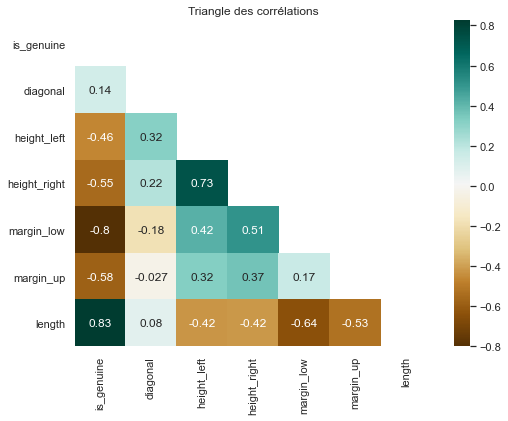

In [14]:
mask = np.triu(np.ones_like(matrix, dtype=np.bool))
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, mask=mask, annot=True, cmap='BrBG')
plt.title('Triangle des corrélations')
save_fig('triangle-correlations')
plt.show()

# ACP

L'analyse en composantes principales va nous permettre de réduire nos 6 variables quantitatives à 2. On pourra alors représenter chaque billet dans un espace à 2 dimensions. Ce qui permettra de vérifier où se situent les vrais et faux billets dans l'espace, et s'ils forment des clusters distincts. L'ACP étant sensible à la variance, on va d'abord standardiser les variables quantitatives.

## Standardisation des variables

Même si toutes les variables s'expriment en millimètres, leur échelle varie. Ici les marges avoisinnent 4mm alors que les longueurs dépassent 170mm. Pour que les valeurs comme celles de la longueur n'aient pas trop de poids face aux autres, il faut que toutes nos variables s'expriment dans la même unité.

Standardiser les variables consiste à les centrer autour de 0, puis réduire à 1 leur écart type (*standard* deviation en anglais, d'où le terme *standardisation*). Le centrage ne change pas la forme d'une distribution, il ne fait que la déplacer.

Pour que la moyenne de chaque variable soit égale à 0, on soustrait à toutes les observations la moyenne de la variable concernée.

In [15]:
import sklearn as sk
from sklearn import preprocessing

In [16]:
X = df.drop(['is_genuine'], axis=1) # Variables quantitatives à standardiser
std_scale = sk.preprocessing.StandardScaler().fit(X) # Fit des valeurs sur le modèle
X_std = pd.DataFrame(std_scale.transform(X), columns=X.columns) # Valeurs standardisées
X_std

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.428344,2.669454,3.096563,-0.131590,-1.189874,0.281633
1,-0.887559,-1.097697,-0.691254,-0.860126,-1.274740,0.780697
2,-0.362742,-1.030427,-0.509439,-0.303010,-1.232307,1.377405
3,-0.461145,-0.963156,-0.842767,-1.260106,-0.213913,1.149571
4,0.358883,-1.232238,-0.539742,0.611230,-3.820725,1.062777
...,...,...,...,...,...,...
165,0.555689,0.550431,1.581436,0.896930,1.738009,-0.857535
166,3.507789,1.761301,1.157201,0.611230,-0.510944,-1.801418
167,1.736529,0.684972,0.520847,0.382670,0.677182,-2.050950
168,-0.395543,-0.324086,-0.145809,0.168395,1.610710,-0.759892


Les variables maintenant standardisées ont toutes le même écart type, proche de 1.

In [17]:
X_std.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02,1.700000e+02
mean,7.695805e-15,3.147286e-14,3.619588e-14,7.523394e-16,-1.504679e-15,-1.375109e-14
std,1.002954e+00,1.002954e+00,1.002954e+00,1.002954e+00,1.002954e+00,1.002954e+00
min,-2.954029e+00,-2.813096e+00,-2.388197e+00,-1.531521e+00,-3.820725e+00,-2.821245e+00
25%,-6.907527e-01,-7.529355e-01,-7.215570e-01,-8.029855e-01,-6.700684e-01,-7.761662e-01
50%,1.447108e-02,-3.818593e-02,6.630909e-02,-2.315852e-01,-1.747245e-03,2.979069e-01
75%,6.458924e-01,7.438342e-01,7.329650e-01,7.362241e-01,6.771821e-01,7.779851e-01
max,3.507789e+00,2.669454e+00,3.096563e+00,2.382571e+00,2.162340e+00,1.529294e+00


Les histogrammes confirment que chaque variable a conservé sa forme de distribution.

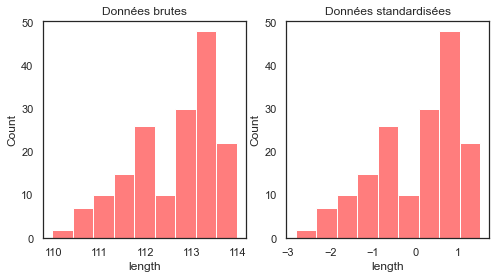

In [18]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
sns.histplot(df['length'], ax=ax[0])
sns.histplot(X_std['length'], ax=ax[1])
ax[0].title.set_text('Données brutes')
ax[1].title.set_text('Données standardisées')
save_fig('histogramme_std')
plt.show()

## Projection sur 2 composantes

L'ACP va nous permettre de visualiser les billets sur un plan à 2 dimensions, en en réduisant les 6 variables standardisées à 2. On compte autant de variables que d'axes d'inertie et de composantes. Chaque composante stocke un certain pourcentage de l'information contenu dans les données, qu'on nomme variance expliquée. La 1ère composante sera celle qui stocke le plus d'informations, donc le plus de variance expliquée dans son vecteur.

In [19]:
matrix = X_std.cov()
matrix

,diagonal,height_left,height_right,margin_low,margin_up,length
diagonal,1.005917,0.321475,0.221722,-0.182092,-0.027527,0.080770
height_left,0.321475,1.005917,0.738736,0.427042,0.326709,-0.423881
height_right,0.221722,0.738736,1.005917,0.512389,0.369089,-0.419488
margin_low,-0.182092,0.427042,0.512389,1.005917,0.172125,-0.641123
margin_up,-0.027527,0.326709,0.369089,0.172125,1.005917,-0.528392
length,0.080770,-0.423881,-0.419488,-0.641123,-0.528392,1.005917


In [20]:
from sklearn.decomposition import PCA

Les 2 premières composantes expliquent 69% de la variance.

In [21]:
n_components = 2 # Nombre de composantes
pca = PCA(n_components=n_components).fit(X_std)
print(
    'Variance expliquée :', 
    round(sum(pca.explained_variance_ratio_) * 100, 1), '%',
    '\nVariance par composante :', pca.explained_variance_ratio_)

Variance expliquée : 69.4 % 
Variance par composante : [0.47447921 0.21957106]


Chaque composante perd en informations par rapport à celle qui la précède : l'analyse des éboulis (*scree plot*) montre leur variance expliquée toujours plus faible.

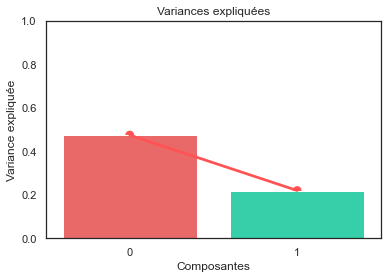

In [22]:
ind = np.arange(0, n_components)
(fig, ax) = plt.subplots(figsize=(6, 4))
sns.barplot(x=ind, y=pca.explained_variance_ratio_)
sns.pointplot(x=ind, y=pca.explained_variance_ratio_)
ax.set_title('Variances expliquées')
ax.set_ylim(0,1)
ax.set_xticks(ind)
ax.set_xticklabels(ind)
ax.set_xlabel('Composantes')
ax.set_ylabel('Variance expliquée')
save_fig('acp_eboulis')
plt.show()

On joint les valeurs des composantes à la dataframe principale, pour pouvoir représenter chaque billet sur le plan factoriel (avec la composante 1 en abscisse et la composante 2 en ordonnée). 

In [23]:
pca = PCA(n_components=n_components)
reduced = pca.fit_transform(X_std)

for i in range(0, n_components): 
    df['PC' + str(i + 1)] = reduced[:, i]
df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,PC1,PC2
0,True,171.81,104.86,104.95,4.52,2.89,112.83,2.153639,1.599709
1,True,171.67,103.74,103.70,4.01,2.87,113.29,-2.110416,-0.526039
2,True,171.83,103.76,103.76,4.40,2.88,113.84,-1.973152,-0.048102
3,True,171.80,103.78,103.65,3.73,3.12,113.63,-2.059795,-0.089105
4,True,172.05,103.70,103.75,5.04,2.27,113.55,-2.403180,0.412170
...,...,...,...,...,...,...,...,...,...
165,False,172.11,104.23,104.45,5.24,3.58,111.78,2.478626,0.189974
166,False,173.01,104.59,104.31,5.04,3.05,110.91,2.585331,2.914472
167,False,172.47,104.27,104.10,4.88,3.33,110.68,2.067245,0.845602
168,False,171.82,103.97,103.88,4.73,3.55,111.87,0.739257,-0.972965


Projetés sur un plan à 2 dimensions, les vrais et faux billets forment bien 2 groupes distincts, qu'on pourrait séparer par une ligne. 

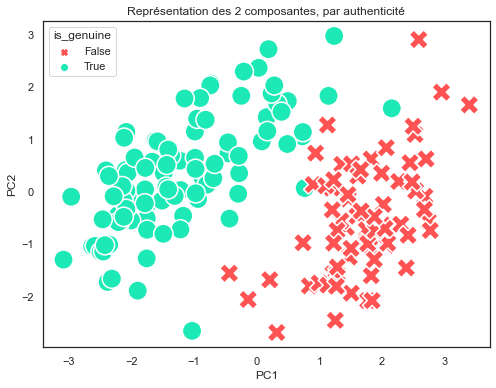

In [24]:
plt.figure(figsize=(8, 6))
scatter_markers = ['X','o']
sns.scatterplot(data=df, x='PC1', y='PC2', style='is_genuine', hue='is_genuine', markers=scatter_markers, s=375)
plt.title('Représentation des 2 composantes, par authenticité')
save_fig('acp_isgenuine')
plt.show()

Le cercle des corrélations confirme que les dépendances entre variables ont bien été conservées après projection. Pour chaque variable, la longueur de la flèche est proportionnelle à la quantité d'informations stockée par les composantes.

La corrélation entre 2 variables se déduit par l'angle que forme leurs flèches :

- 0° : corrélation positive
- 90° : absence de corrélation
- 180° : corrélation négative

Les corrélations entre les 6 variables de départ ont bien été conservées après réduction en 2 dimensions. Ici, les hauteurs gauche et droite sont bien corrélées positivement, tout comme les 2 marges. L'ACP a conservé suffisamment de données pour que la représentation sur le plan factoriel soit fiable.

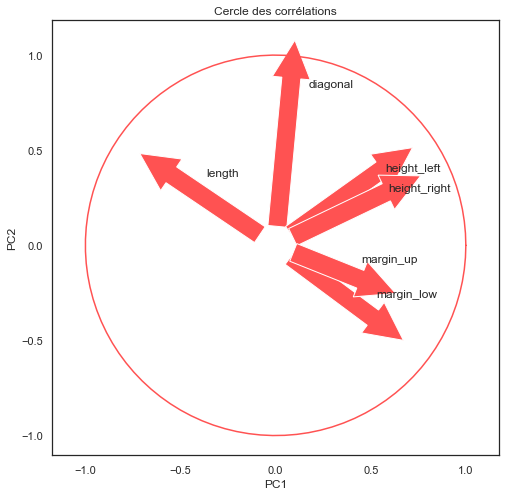

In [25]:
# Plot a variable factor map for the first two dimensions.
(fig, ax) = plt.subplots(figsize=(8, 8))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.2,
             head_length=0.2, width=.1, head_starts_at_zero=True)
    
    plt.text(pca.components_[0, i] + .1,
             pca.components_[1, i] + .05,
             X_std.columns.values[i])

an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Cercle des corrélations')
save_fig('cercle-correlations')
plt.show()

# Clustering

L'algorithme **K-means** va permettre de vérifier si les données sont bien linéaires, séparables en 2 groupes distincts dans l'espace en 2 dimensions. C'est à cette condition qu'on pourra s'appuyer sur une régression logistique pour classer les billets.

On fixe le nombre de clusters à 2, étant donné qu'on cherchera par la régression logistique à déduire les 2 classes de *is_genuine*.

In [26]:
from sklearn import cluster

In [27]:
kmeans = sk.cluster.KMeans(n_clusters=2, random_state=0).fit(X)
df['cluster'] = kmeans.predict(X)
dicto = {0: 1, 1: 0} # Inversion des 0 et des 1
df['cluster'] = df['cluster'].map(dicto) # Pour que 0 soit égal à False
df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,PC1,PC2,cluster
0,True,171.81,104.86,104.95,4.52,2.89,112.83,2.153639,1.599709,1
1,True,171.67,103.74,103.70,4.01,2.87,113.29,-2.110416,-0.526039,1
2,True,171.83,103.76,103.76,4.40,2.88,113.84,-1.973152,-0.048102,1
3,True,171.80,103.78,103.65,3.73,3.12,113.63,-2.059795,-0.089105,1
4,True,172.05,103.70,103.75,5.04,2.27,113.55,-2.403180,0.412170,1
...,...,...,...,...,...,...,...,...,...,...
165,False,172.11,104.23,104.45,5.24,3.58,111.78,2.478626,0.189974,0
166,False,173.01,104.59,104.31,5.04,3.05,110.91,2.585331,2.914472,0
167,False,172.47,104.27,104.10,4.88,3.33,110.68,2.067245,0.845602,0
168,False,171.82,103.97,103.88,4.73,3.55,111.87,0.739257,-0.972965,0


Les clusters prédits correspondent à vue d'oeil aux vraies classes (*is_genuine*), et on peut comme attendu séparer les clusters par une ligne droite. Nos données sont donc adaptées pour une régression logistique.

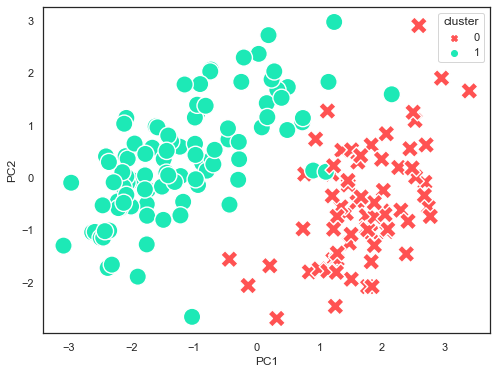

In [28]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster', style='cluster', markers=scatter_markers, s=300)
save_fig('kmeans-clusters')
plt.show()

Si on projette sur le même plan la vraie classe (*is_genuine*) et la classe prédite (*cluster*), seuls 3 billets apparaîssent mal classés (les plus gros points indiquent la classe réelle, les petits le cluster).

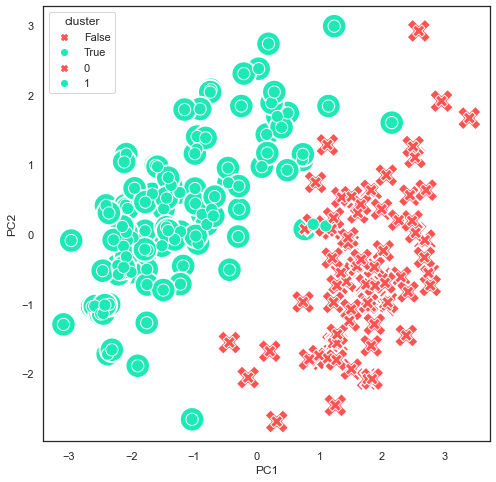

In [29]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=df, x='PC1', y='PC2', markers=scatter_markers, style='is_genuine', hue='is_genuine', s=600)
sns.scatterplot(data=df, x='PC1', y='PC2', markers=scatter_markers, style='cluster', hue='cluster', s=150)
save_fig('kmeans_comparaison')
plt.show() # Contour = classe réelle ; Point = cluster

On vérifie le nombre d'individus vrais détectés faux 
avec une **matrice de confusion**.

|                      | Prédit : faux  | Prédit : vrai  |
| -------------------- |:-------------: | -------------: |
| Valeur réelle : faux | Vrais négatifs | Faux positifs  |
| Valeur réelle : vrai | Faux négatifs  | Vrais positifs |

Deux faux billets ont été considérés comme vrais par le clustering, et seul un vrai billet a été détecté comme faux.

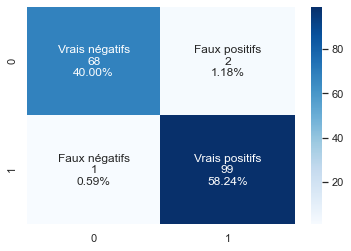

              precision    recall  f1-score   support

       False       0.99      0.97      0.98        70
        True       0.98      0.99      0.99       100

    accuracy                           0.98       170
   macro avg       0.98      0.98      0.98       170
weighted avg       0.98      0.98      0.98       170



In [30]:
def matrice_confusion(a, b, nom_graphique):
    confusion_matrix = sk.metrics.confusion_matrix(a,b)
    group_names = ['Vrais négatifs','Faux positifs','Faux négatifs','Vrais positifs']
    group_counts = ['{0:0.0f}'.format(value) for value in confusion_matrix.flatten()]
    group_percentages = [
        '{0:.2%}'.format(value) for value in confusion_matrix.flatten()/np.sum(confusion_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')
    save_fig(nom_graphique)
    plt.show()
    
    classification = sk.metrics.classification_report(a,b)
    print(classification)
    
matrice_confusion(df['is_genuine'], df['cluster'], 'kmeans_matrice-confusion')

# Modélisation

## Split

On dissocie *is_genuine* (qu'on appelle `y` : la target) des autres variables standardisées (`X`). 

In [31]:
y = df['is_genuine'] # Target
y

0       True
1       True
2       True
3       True
4       True
       ...  
165    False
166    False
167    False
168    False
169    False
Name: is_genuine, Length: 170, dtype: bool

Puis `X` et `y` sont divisés en 2 échantillons `train` et `test`. Les jeux test représenteront ici un tiers des données.

In [32]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X_std, y, test_size=0.33, random_state=42)

print('X_train :', len(X_train), 'lignes',
    '\ny_train :', len(y_train), 'lignes',
    '\nX_test :', len(X_test), 'lignes',
    '\ny_test :', len(y_test), 'lignes')

X_train : 113 lignes 
y_train : 113 lignes 
X_test : 57 lignes 
y_test : 57 lignes


## Classifieur idiot

On crée un classifieur idiot aux prédictions aléatoires donc médiocres, comme base de comparaison avec notre futur modèle. 

En spécifiant `strategy='uniform'`, on obtient des prédictions aléatoires sans rapport avec nos données. En spécifiant `prior`, on obtiendrait pour chaque individu la classe la plus fréquente dans le jeu de données.

In [33]:
from sklearn.dummy import DummyClassifier
dummy_biased = DummyClassifier(random_state=0, strategy='uniform')
dummy_biased.fit(X_train, y_train)
y_pred_dummy = dummy_biased.predict(X_test) # Prédiction de la target sur les variables de test (X_test)
print(y_pred_dummy)

[False  True  True False  True  True  True  True  True  True  True False
 False  True False False False False False  True False  True  True False
 False  True  True  True  True False  True False  True False  True  True
 False  True  True False False  True False  True  True  True  True  True
 False  True False  True  True  True  True False  True]


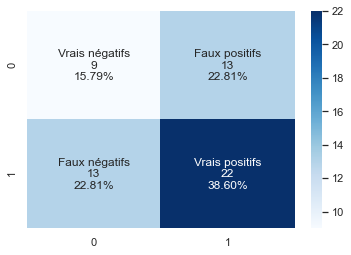

              precision    recall  f1-score   support

       False       0.41      0.41      0.41        22
        True       0.63      0.63      0.63        35

    accuracy                           0.54        57
   macro avg       0.52      0.52      0.52        57
weighted avg       0.54      0.54      0.54        57



In [34]:
matrice_confusion(y_test, y_pred_dummy, 'dummy_matrice-confusion')

## Régression logistique

En sortie, on obtient pour chaque billet la probabilité qu'il soit vrai, et celle qu'il soit faux.

In [35]:
regression = sk.linear_model.LogisticRegression()
regression.fit(X_train, y_train)

pd.DataFrame(
    regression.predict_proba(X_test)).rename(
    columns={0: 'False', 1: 'True'}).head(10)

,False,True
0,0.891750,0.108250
1,0.008633,0.991367
2,0.996318,0.003682
3,0.000202,0.999798
4,0.495264,0.504736
5,0.997718,0.002282
6,0.963555,0.036445
7,0.063299,0.936701
8,0.960113,0.039887
9,0.004716,0.995284


On obtient une constante (intercept), et pour chaque variables un coefficient de corrélation, sur lesquels se basera la fonction de régression linéaire.
>h(x) = diagonal*0.1388 + ... + length*1.8254 + constante

Pour obtenir l'équation de notre régression logistique, on appliquera ensuite cette formule : 
>f(x) = 1/(1+exp(-h(x)))

In [36]:
print('Constante :', regression.intercept_)

Constante : [0.90023436]


In [37]:
print('Coefficients :', regression.coef_)

Coefficients : [[ 0.13882195 -0.19305063 -0.50972116 -1.92453316 -1.43368165  1.82541401]]


La plus forte probabilité pour chaque individu détermine sa classe prédite, qu'on récupére pour ensuite pouvoir la comparer avec **y_test**.

In [38]:
y_log = regression.predict(X_test) # Prédictions sur l'échantillon-test
print(y_log)

[False  True False  True  True False False  True False  True  True False
 False  True  True  True  True False  True False  True  True  True  True
  True  True  True  True  True  True  True  True False False False False
  True  True False False  True False  True False False  True  True  True
 False  True False False  True  True  True False  True]


En comparant la target réelle du jeu test et nos prédictions, on constate qu'un seul faux billet a été prédit comme vrai, et un vrai billet a été considéré faux.

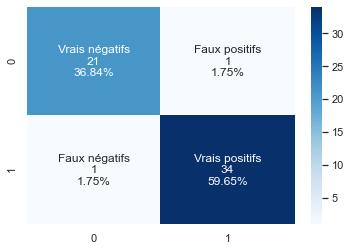

              precision    recall  f1-score   support

       False       0.95      0.95      0.95        22
        True       0.97      0.97      0.97        35

    accuracy                           0.96        57
   macro avg       0.96      0.96      0.96        57
weighted avg       0.96      0.96      0.96        57



In [39]:
matrice_confusion(y_test, y_log, 'reg_matrice-confusion')

# Shap

SHAP est un outil permettant d'expliquer la sortie d'un modèle. Les variables y sont classées par leur force de contribution au modèle. Comme attendu, la longueur et la marge basse arrivent en tête.

En abscisse, l'impact de chaque variable sur le modèle. Les valeurs rouges indiquent les plus grandes valeurs de la variable, les bleues ses plus faibles. Le modèle est surtout influencé par les marges basses les plus faibles (en bleu) et les plus grandes des longueurs.

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


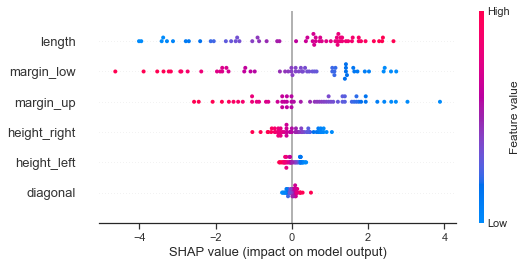

In [40]:
import shap
explainer = shap.LinearExplainer(regression, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns.to_list())

`force_plot` permet pour chaque billet de vérifier quelles variables ont impacté les 2 probabilités de classe. Ici, la marge basse et la longueur pointent en bleu et vers la gauche : elles ont contribué à la classe *False*.  

In [41]:
def force_plot(num_billet):
    print('Billet', num_billet, ':', y_test.iloc[num_billet])
    shap.initjs()
    return shap.force_plot(
        explainer.expected_value, shap_values[num_billet], 
        X_test.iloc[num_billet].values, feature_names=X.columns.to_list())
    
force_plot(5)

Billet 5 : False


Quand les variables pointent en rouge vers la droite, elle contribuent à la classe positive.

In [42]:
force_plot(24)

Billet 24 : True


# Programme de détection

Pour détecter l'authenticité des billets, le programme acceptera un fichier CSV sur ce modèle :

In [43]:
pd.read_csv('example.csv')

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


On stocke les données d'entraînement dans un dictionnaire qu'on enregistera dans un fichier Pickle.

In [44]:
train_dict = {}
train_dict[0] = std_scale
train_dict[1] = regression
train_dict[2] = pca

`pickle.dump()` sérialise le dictionnaire, enregistré dans le fichier **train.p**. Pour désérialiser dans la fonction notre dictionnaire de dataframes, on utilisera `pickle.load()`. 

In [45]:
import pickle

In [46]:
pickle.dump(train_dict, open('train.p', 'wb'))

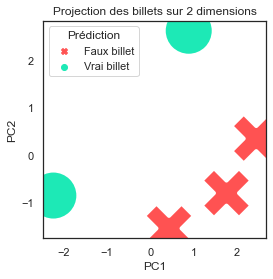

,Prédiction,Probabilité de faux,Probabilité de vrai,id
0,Faux billet,0.962899,0.037101,A_1
1,Faux billet,0.994102,0.005898,A_2
2,Faux billet,0.986890,0.013110,A_3
3,Vrai billet,0.058722,0.941278,A_4
4,Vrai billet,0.004059,0.995941,A_5


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.decomposition import PCA
import pickle

def detection(billets_csv): # Programme de détection des faux billets
 
    train_dict = pickle.load(open('train.p', 'rb'))
    std_scale = train_dict[0]
    regression = train_dict[1]
    pca = train_dict[2]
   
    
    billets = pd.read_csv(billets_csv) # en cas de modif du fichier, ajouter sep='\t')
    X_csv = billets.drop(['id'], axis=1)    
    X_csv = pd.DataFrame(std_scale.transform(X_csv), columns=X_csv.columns) # CSV standardisé
    
    
    y_log = regression.predict(X_csv) # Prédictions
    predictions = []
    for i in range(0, len(y_log)):
        predictions.append(y_log[i])
    
    predictions = pd.concat([ # Jointure des prédictions
        pd.DataFrame(
        [predictions]).rename(index={0: 'Prédiction'}).T.replace(
        {False: 'Faux billet', True: 'Vrai billet'}),
        pd.DataFrame(
        regression.predict_proba(X_csv)).rename(
        columns={0: 'Probabilité de faux', 1: 'Probabilité de vrai'})], axis=1)
    predictions['id'] = billets['id'].unique() 
    
    n_components = 2 # ACP
    reduced = pca.transform(X_csv)
    for i in range(0, n_components):
        predictions['PC' + str(i + 1)] = reduced[:, i]   
    plt.figure(figsize=(4,4))
    sns.scatterplot(data=predictions, x='PC1', y='PC2', markers=['X','o'],
                    hue='Prédiction', style='Prédiction', s=2500, palette=['#ff5252', '#1de9b6'])
    plt.title('Projection des billets sur 2 dimensions')
    plt.show()
    
    return predictions.iloc[:,:-2]
    
detection('example.csv')

# Ressources

- [A Step-by-Step Explanation of Principal Component Analysis (PCA)](#https://builtin.com/data-science/step-step-explanation-principal-component-analysis)
- [StatQuest : Principal Component Analysis (PCA)](#https://www.youtube.com/watch?v=FgakZw6K1QQ)
- [What Is Normalization and When To Apply?](#https://medium.com/analytics-vidhya/what-is-normalization-and-when-to-apply-bfdf34153bcf)
- [When is precision more important over recall?](#https://www.quora.com/When-is-precision-more-important-over-recall)
- [StatQuest: K-means clustering](#https://www.youtube.com/watch?v=4b5d3muPQmA)
- [La régression logistique en Machine Learning : déjouez ses faiblesses](#https://www.youtube.com/watch?v=qToXVhFWGPg)
- [Beginners Take: How Logistic Regression is related to Linear Regression](#https://www.analyticsvidhya.com/blog/2020/12/beginners-take-how-logistic-regression-is-related-to-linear-regression/)